In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

In [2]:

df_03 = pd.read_csv('data/stemmed_merged_kubu_03.csv')

In [3]:
indo_stopwords = [
    # Basic Indonesian stopwords
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    
    # Candidate names and references (since they appear in nearly every tweet)
    "ganjar", "pranowo", "mahfud", "md", "gp", "gama", "prabowo", "gibran", "megawati",
    
    # Common Balinese campaign greeting (appears frequently)
    "rahajeng", "rawuh", "bal", "bali", "dewata", "pulau",
    
    
    # Location indicators
    "indonesia", "jakarta", "jawa", "timur", "barat", "tengah", "sumatra", "utara", 
    "selatan", "kota", "daerah", "provinsi", "wilayah", "region",
]

In [4]:

vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=5,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=5,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)


# Fit the model
topics, probs = topic_model.fit_transform(df_03['full_text'].tolist())

2025-05-22 22:08:52,965 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1183 [00:00<?, ?it/s]

2025-05-22 22:08:59,270 - BERTopic - Embedding - Completed ✓
2025-05-22 22:08:59,271 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-22 22:09:28,740 - BERTopic - Dimensionality - Completed ✓
2025-05-22 22:09:28,741 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-22 22:17:07,922 - BERTopic - Cluster - Completed ✓
2025-05-22 22:17:07,923 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-22 22:17:08,636 - BERTopic - Representation - Completed ✓
2025-05-22 22:17:08,637 - BERTopic - Topic reduction - Reducing number of topics
2025-05-22 22:17:08,656 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-22 22:17:09,110 - BERTopic - Representation - Completed ✓
2025-05-22 22:17:09,113 - BERTopic - Topic reduction - Reduced number of topics from 472 to 15


In [5]:
# Generate more intuitive topic labels for Ganjar's campaign
topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Outlier"
        continue
        
    # Get top words
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to Ganjar campaign themes based on keywords
    if any(term in words for term in ["bal", "bali", "rahajeng", "rawuh"]):
        topic_labels[topic_id] = "Kampanye Bali"
    elif any(term in words for term in ["jawa", "tengah", "jateng", "banteng"]):
        topic_labels[topic_id] = "Basis Dukungan Jawa Tengah"
    elif any(term in words for term in ["legislatif", "eksekutif", "yudikatif", "jejak", "rekam"]):
        topic_labels[topic_id] = "Pengalaman Pemerintahan"
    elif any(term in words for term in ["fokus", "dukung", "motivasi", "kembang"]):
        topic_labels[topic_id] = "Dukungan & Motivasi"
    elif any(term in words for term in ["demokrasi", "partai", "pdip", "banteng", "merah"]):
        topic_labels[topic_id] = "Dukungan Partai PDI-P"
    elif any(term in words for term in ["dame", "hati", "adem", "damai", "sejuk"]):
        topic_labels[topic_id] = "Citra Kepemimpinan Adem"
    elif any(term in words for term in ["aspirasi", "dengar", "blusuk", "jumpa"]):
        topic_labels[topic_id] = "Pendekatan ke Masyarakat"
    elif any(term in words for term in ["tegak", "lurus", "jujur", "bersih"]):
        topic_labels[topic_id] = "Integritas & Kejujuran"
    elif any(term in words for term in ["huru", "hara", "politik", "sembuh", "luka"]):
        topic_labels[topic_id] = "Perbaikan Situasi Politik"
    elif any(term in words for term in ["penjuru", "nusantara", "kenal"]):
        topic_labels[topic_id] = "Popularitas Nasional"
    else:
        # Use the first few words as a generic label
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)

In [6]:
# import wordcloud
from wordcloud import WordCloud


Improved Topic Information:
   Topic  Count                                               Name  \
0     -1  11686                      -1_pilih 03_sosok_allah_papua   
1      0  18250           0_politik_cinta_sejahtera_wakil presiden   
2      1   3159               1_03 menang_pilih 03_03 03_menang 03   
3      2   1685           2_partai_juang_suara rakyat_dengar suara   
4      3    741  3_program program_program kerja_program unggul...   
5      4    728          4_debat_kritik_malam_calon wakil presiden   
6      5    498          5_internet_gratis_internet gratis_digital   
7      6    322               6_ekonomi_produk_infrastruktur_lokal   
8      7    224                         7_porno_video_tonton_viral   
9      8    171                8_strategi_strategis_terobos_proyek   

                                         CustomName  \
0                                           Outlier   
1                         Perbaikan Situasi Politik   
2                      03 menang & 

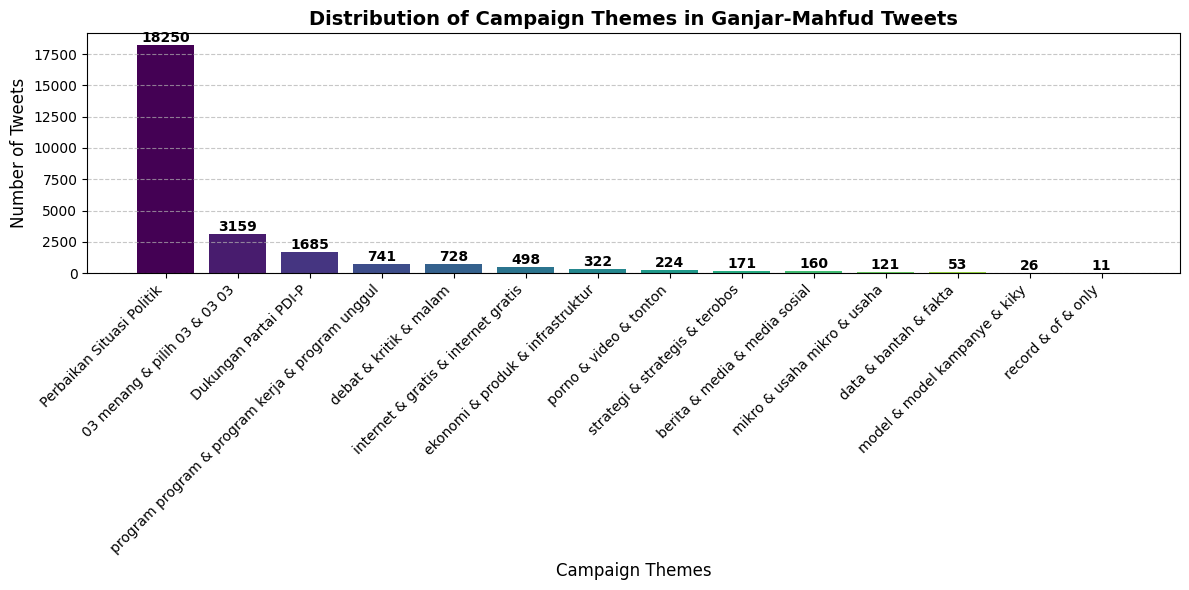

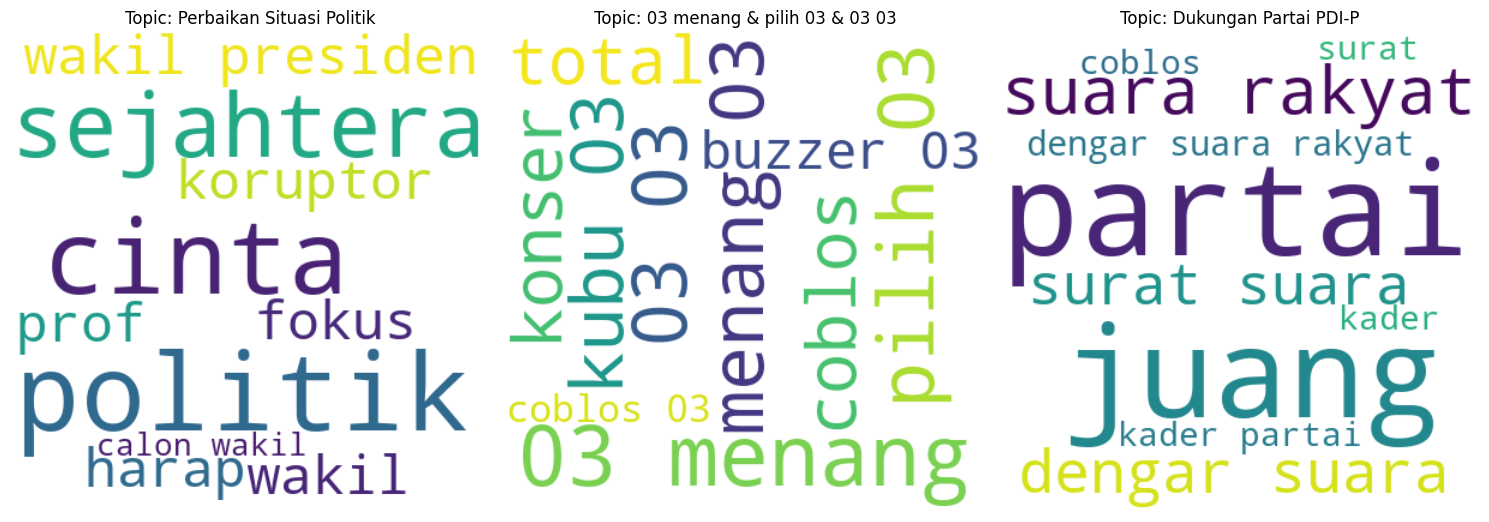

In [7]:
# Get the improved topic information
topic_info = topic_model.get_topic_info()
print("\nImproved Topic Information:")
print(topic_info.head(10))

# Print topics with their new labels
print("\nCampaign Themes for Ganjar-Mahfud:")
for index, row in topic_info.iterrows():
    if row["Topic"] != -1:  # Skip outlier topic
        topic_id = row["Topic"]
        words = [word[0] for word in topic_model.get_topic(topic_id)[:8]]
        print(f"Theme: {row['Name']}")
        print(f"Keywords: {', '.join(words)}")
        print(f"Document count: {row['Count']}")
        print("-" * 50)

# Create a topic distribution visualization
plt.figure(figsize=(12, 6))
topic_counts = topic_info[topic_info["Topic"] != -1]["Count"]
topic_names = [label for topic, label in topic_labels.items() if topic != -1][:len(topic_counts)]

# Plot with better color scheme
bars = plt.bar(topic_names, topic_counts, color=plt.cm.viridis(np.linspace(0, 1, len(topic_counts))))

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Campaign Themes in Ganjar-Mahfud Tweets", fontsize=14, fontweight='bold')
plt.xlabel("Campaign Themes", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display interactive visualizations
intertopic_map = topic_model.visualize_topics()
display(intertopic_map)

# Create hierarchical clustering visualization
hierarchy = topic_model.visualize_hierarchy()
display(hierarchy)

# Create heatmap of topic similarities
heatmap = topic_model.visualize_heatmap()
display(heatmap)

# Create word clouds for top 3 topics
plt.figure(figsize=(15, 10))
for i, topic_id in enumerate(topic_info[topic_info['Topic'] != -1]['Topic'][:3]):
    plt.subplot(1, 3, i+1)
    
    # Get topic words and weights
    words = dict(topic_model.get_topic(topic_id)[:15])
    
    # Create and display wordcloud
    wordcloud = WordCloud(width=400, height=400, background_color='white', 
                          colormap='viridis', max_words=50).generate_from_frequencies(words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic: {topic_labels[topic_id]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from wordcloud import WordCloud
import seaborn as sns

In [9]:
# Create topic distribution from the existing topic_info
topic_distribution = topic_info.set_index("Topic")["Count"]

# Get representative documents for key campaign themes
print("\nRepresentative tweets for key campaign themes:")
key_topics = [t for t in topic_distribution.index if t != -1][:5]

for topic_id in key_topics:
    theme_name = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic_id, "Name"].values[0]
    print(f"\n--- Theme: {theme_name} ---")
    rep_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(rep_docs[:3]):
        print(f"{i+1}. {doc[:200]}...")


Representative tweets for key campaign themes:

--- Theme: 0_politik_cinta_sejahtera_wakil presiden ---
1. fokus isu korupsi repot kubu parah kubu ganjar duga libat e kartu tanda duduk gibran adu komisi berantas korupsi ubaidillah badrun lebar partai partai koalisi...
2. tabrak prof ketua anggota sangsi ingat keras dkpp proses daftar gibran calon wakil presiden calon wakil presiden 03 ketua komisi pemelihan hasyim asy ari bica pecat langgar...
3. yarakat solo penuh sukacita pesan positif doa baik ganjar pranowo prof mahfud kampany3 akbar sejahtera lipat ganda indonesia makmur sentosa...

--- Theme: 1_03 menang_pilih 03_03 03_menang 03 ---
1. sukses konser salam m3tal 03 menang total malam ganjar sejahtera...
2. totalitas dukung pasang calon no 03 hadir konser hajat rakyat gelora karno kali sejahtera indonesia jaya...
3. ramai gelora karno gembira dukung pasang calon no 03 ganda sejahtera raih makmur lanjut...

--- Theme: 2_partai_juang_suara rakyat_dengar suara ---
1. keluarga jokowi 